## Model Agnostic Ablation Example

Currently we only support training full experiments with pytorch models and captum explanations. However, `ablation` can still be utilized to generate ablation curves given a model and set of explanations. 

Below is an example that creates a new dataset, uses a `RandomForestClassifier` and generates explanations with `shap.TreeExplainer`

### Create Dataset

Datasets need to come with a few extra attributes to support categorical variables. We have a simple `NumpyDataset` class that holds all the necessary information. 

For this example we will use the German dataset, label encode the categoricals, and leave all other features as is. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from ablation.dataset import NumpyDataset

In [2]:
def prepare_german_data():
    """Prepare German dataset

    Returns:
        NumpyDataset: dataset
    """

    data = pd.read_csv("../ablation/data/MyGermanData.csv")
    X, y = data.drop("credit.rating", axis=1), data["credit.rating"]

    cat_ix = X.select_dtypes(include=["object"]).columns
    num_ix = X.select_dtypes(exclude=["object"]).columns

    X_train, X_test, y_train, y_test = train_test_split(X, y.values.flatten(), test_size=0.2)
    encoder = OrdinalEncoder()
    identity = FunctionTransformer(feature_names_out = "one-to-one")

    ct = ColumnTransformer(
        [("categoricals", encoder, cat_ix), ("numericals", identity, num_ix)],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    return NumpyDataset(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        n_classes=2,
        feature_names=list(ct.get_feature_names_out()),
        original_feature_names=cat_ix.tolist() + num_ix.tolist(),
    )

In [3]:
dataset = prepare_german_data()

### Model Fit

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
rf = RandomForestClassifier().fit(dataset.X_train, dataset.y_train)

### Generate Explanations


In [55]:
%pip install shap

In [10]:
from shap import TreeExplainer

In [11]:
te = TreeExplainer(rf)
shap_values = te.shap_values(dataset.X_test)[0]

### Run Ablation

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from ablation.perturb import generate_perturbation_distribution
from ablation.ablation import Ablation

Generate a perturbation distribution with a given method

In [13]:
perturbation = generate_perturbation_distribution(
    method="marginal", X=dataset.X_train, X_obs=dataset.X_test
)

In [14]:
abtn = Ablation(
    perturbation,
    rf,
    dataset,
    dataset.X_test,
    dataset.y_test,
    explanation_values = shap_values,
    explanation_values_dense = shap_values,
    random_feat_idx=dataset.dense_random_feat_idx,
    scoring_methods=["auroc"],
    local=True,
)

result = abtn.ablate_features()

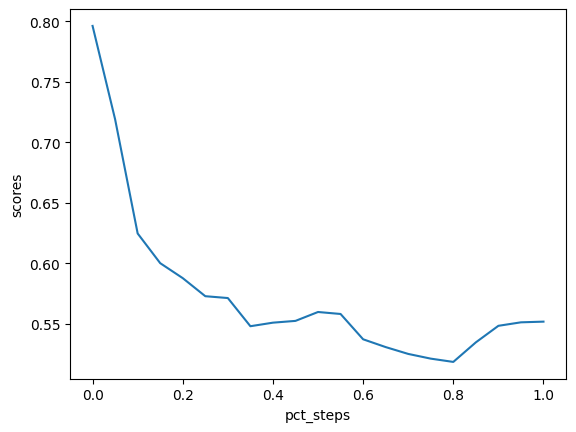

In [15]:
sns.lineplot(
    data=result,
    x="pct_steps",
    y="scores",
    palette="colorblind",
    legend=False,
)
plt.show()